# 1. Inicjalizacja

In [1]:
import numpy as np
import os, subprocess
from matplotlib import pyplot as plt
from scipy.optimize import least_squares
from struct import *

import can
import time
import math
from IPython.display import display, clear_output
from joint_can import *
%matplotlib inline


In [2]:
def initialize_joint(bus):
    send_msg(0x0A0, None, bus)
    time.sleep(1)
    
    send_msg(0x0b0, [0,0,0,0,0,0], bus)
    time.sleep(0.1)
    send_msg(0x040, None, bus)
    time.sleep(0.1)
    send_msg(0x0a0, None, bus)
    time.sleep(1)
    
    if (send_msg(0x0F0, [2, 2], bus).data[0] == 1):
        send_msg(0x010, [2], bus)
        time.sleep(1)
        print(send_msg(0x010, [3], bus).data[0])
        time.sleep(5)
        return True
    else:
        return False
     

In [3]:
def save_data(data: np.array, file_path: str, serial_nr: str) -> None:
    with open(file_path+'/'+serial_nr+'/'+serial_nr+time.strftime('_%y_%m_%d_%H_%M')+'.txt','w') as file:
        file.write("serial number: " + serial_nr+'\n')
        file.write("torque: "+str(torque)+'\n')
        
        file.write("start_temp: "+str(temps[1][0]) +" ("+str(temps[0][0])+")\n")
        file.write("finish_temp: "+str(temps[1][1]) +" ("+str(temps[0][1])+")\n")
        
        file.write("note: " + note+'\n')
        for line in data:
            file.write(f'{line[0]:.6f} {line[1]:.6f}\n')

In [4]:
os.popen('/home/pi/mech_diagnostics/can_down.sh')
time.sleep(1)
os.popen('/home/pi/mech_diagnostics/can_up.sh')
time.sleep(1)

bus = can.interface.Bus(bustype='socketcan', channel='can0', bitrate=1000000, data_bitrate=5000000, fd=True)
print(bus)
initialize_joint(bus)

socketcan channel 'can0'
2


True

# Parametry kalibracji

In [5]:
serial="JANUSZ_4_RI70_21414863" #musi byc min jedna litera w numerze
path = "/home/pi/mech_diagnostics/friction_data"

#zakres temperatur
min_temp = 30
max_temp = 31
speed = 1. #predkosc na ktorej joint jest rozgrzewany

# parametry kalibracji
max_speed = 1.   # maksymalna prędkość kalibracji
speed_step = 0.05   # krok zmiany prędkości
loop_num = 6  # ilość powtórzeń pętli kalibracji

# Blok główny kalibracji

In [6]:
# ustalenie temperatury jointa (grzenie lubj schładzanie)
c_speed=0.
j_data=set_speed(c_speed,bus)

while(j_data.bearing_temp<min_temp or j_data.bearing_temp>max_temp):
    if j_data.bearing_temp<min_temp:
        c_speed=speed
    else:
        c_speed=0.
    j_data=set_speed(c_speed,bus)
    print(f'\r tq: {j_data.torque:.3f}\tm_temp: {j_data.motor_temp:.3f}\tb_temp: {j_data.bearing_temp:.3f}', end='')
    time.sleep(1)
send_msg(0x0A0, None, bus)

 tq: 10.756	m_temp: 30.000	b_temp: 30.000

In [7]:
# początek kalibracji
try: 
    os.mkdir(path+'/'+serial) 
except OSError as error: 
    pass

In [8]:
while not initialize_joint(bus):
    print("Joint initialization in progress")


2


In [9]:
print("Running friction calibration...")
data=[]
current_speed = 0.  
run_direction = 1
loop_counter = 0
current_reading = set_speed(current_speed,bus)

time.sleep(5)
while(loop_counter<loop_num):
    current_speed += speed_step*run_direction
    
    while(abs(current_speed) > speed_step/2 or run_direction == -1):
        if current_speed > max_speed:
            run_direction = -1
        else:
            if current_speed < -max_speed:
                run_direction = 1
                
        current_speed += speed_step*run_direction
        
        start_time=time.time()
        
        while((cur_time:=time.time()-start_time)<5):
            current_reading=set_speed(current_speed,bus)
            print(f'\r Loops left: {loop_counter} / {loop_num}. Current speed: {current_speed:.3f} ({current_reading.speed:.3f}).\t\t\t\t', end='')
            if(abs(current_reading.speed)>0.01):
                data.append([current_reading.speed, current_reading.torque , current_reading.bearing_temp])
                
    loop_counter += 1
    
        
set_speed(0.,bus)
print(f'\r Loops left: {loop_counter} / {loop_num}. Current speed: {current_speed:.3f} ({current_reading.speed:.3f}).\t\t\t\t', end='')

Running friction calibration...
 Loops left: 6 / 6. Current speed: -0.000 (0.000).					

# Ruch do pozycji zerowej

In [10]:
# żeby wykonać ruch do pozycji zerowej uruchomić inicjalizcję (bloki 1.1 do 1.5

send_msg(0x0A0, None, bus)
time.sleep(1)
send_msg(0x0F0, [2,2], bus)
send_msg(0x010, [2], bus)
time.sleep(0.1)
send_msg(0x010, [3], bus)
time.sleep(6)


temp_data=set_speed(0,bus)

sgn=-(int(temp_data.position>0) - int(temp_data.position<0))

temp_data=set_speed(sgn*0.1,bus)

while(abs(temp_data.position)>0.01):
    if (abs(temp_data.position)>0.2):
        temp_data=set_speed(sgn*0.2,bus)
    else:
        temp_data=set_speed(sgn*0.05,bus)
    time.sleep(0.1)

send_msg(0x010, [2], bus)
print(temp_data.position)

0.009204025171735415


# Obliczenie parametrów równania tarcia

In [11]:
def model(k, v, t, tq):
    return (1 + k[4]*(t - k[5])) * (k[0] * np.sign(v) + k[1] * v + k[2] * v ** 2 * np.sign(v) + k[3] * v ** 3) - tq


def fun(k, v, t):
    return (1 + k[4]*(t - k[5])) * (k[0] * np.sign(v) + k[1] * v + k[2] * v ** 2 * np.sign(v) + k[3] * v ** 3)

In [12]:
flist=os.listdir(path+'/'+ serial)
for file in flist:
    if file[0] == '.':
        flist.remove(file)

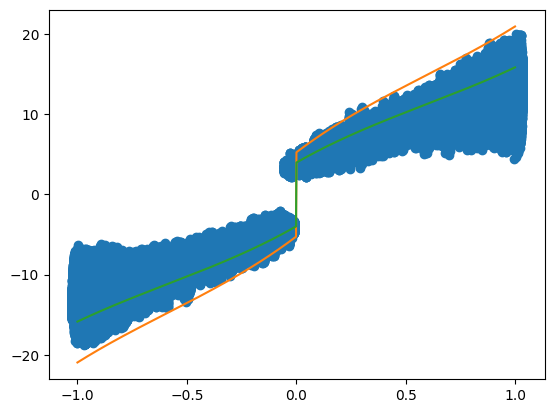

can.Message(timestamp=1663927135.5661082, arbitration_id=0x240, is_extended_id=False, channel='can0', dlc=1, data=[0x1], is_fd=True, bitrate_switch=True, error_state_indicator=False)

In [13]:
# for dir in dlist:
#     data_points = []
#     files_processed = 0
#     flist = os.listdir(path + '/' + dir)


# flist=os.listdir(path+'/'+ serial)
# data_points=[]
# files_processed = 0
# for fname in flist:
#     if '.txt' in fname and 'coeffs' not in fname:
#         with open(path + '/' + serial + '/' + fname) as file:
#             data_points += (list(file))
#             files_processed += 1
# data_points = [point.split() for point in data_points]

#bylo zakomentowane wszystko powyzej, --> Dodo

data_points = np.array(data, dtype=float)

tq_train = data_points[:, 1]
v_train = data_points[:, 0]
t_train = data_points[:, 2]
k0 = [5., 15., 0., -5., -0.1, 20.]
res_lsq = least_squares(model, k0, args=(v_train, t_train, tq_train), jac='3-point', loss='cauchy',
                        max_nfev=10000000, gtol=1e-10, ftol=1e-12)

plt.plot(v_train, tq_train, 'o')
v_test = np.linspace(-1, 1, 1000)

y_lsq = fun(res_lsq.x, v_test, 20)
plt.plot(v_test, y_lsq)

y_lsq = fun(res_lsq.x, v_test, 30)
plt.plot(v_test, y_lsq)

plt.show()

friction_data=[96,12]
send_msg(0x0a0, None, bus)
time.sleep(1)
with open(path + '/' + serial + '/' + 'friction_coeffs' + '.txt', 'w') as file:
    for c in res_lsq.x:
        friction_data.append(float(c))
        file.write(str(c) + '\n')
friction_data_b=pack('>BBffffff',*friction_data)
send_msg(0x030, friction_data_b, bus)
send_msg(0x040, None, bus)
